# Load Dataset:

In [22]:
import zipfile
import os
from PIL import Image

# Replace 'your_zip_file.zip' with the actual name of your zip file
zip_file_path = 'archive.zip'

# Specify the directory where you want to extract the images
extracted_path = 'C:/Users/Abhishek_Jaiswal/Documents/EmbeddingALL/dataset/'

# Create the directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Function to organize images into folders based on folder names
def organize_images(input_path, output_path):
    for root, dirs, files in os.walk(input_path):
        for file in files:
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            label_path = os.path.join(output_path, label)

            # Create the label folder if it doesn't exist
            os.makedirs(label_path, exist_ok=True)

            # Move the image to the corresponding label folder
            new_image_path = os.path.join(label_path, file)

# Organize the images
organize_images(extracted_path, 'organized_images')

# Read and Augment Images

In [1]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import numpy as np

def load_and_augment_images(root_folder, image_size=(224, 224), test_size=0.2, random_state=42):
    data = []
    labels = []
    label_dict = {}  # Mapping from label names to numerical indices

    for idx, label in enumerate(os.listdir(root_folder)):
        label_path = os.path.join(root_folder, label)
        if os.path.isdir(label_path):
            label_dict[label] = idx  # Assign numerical index to each label
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)

                # Load and resize the image
                img = load_img(img_path, target_size=image_size)

                # Convert image to NumPy array
                img_array = img_to_array(img)

                # Reshape to (1, height, width, channels) as flow() expects a 4D input
                img_array = np.expand_dims(img_array, axis=0)

                # Augment the image
                datagen = ImageDataGenerator(
                    rotation_range=10,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest'
                )

                augmented_images = datagen.flow(img_array)

                # Add both original and augmented images to the data
                data.extend(augmented_images)
                labels.extend([label] * len(augmented_images))

    # Convert labels to numerical format (one-hot encoding)
    labels_numerical = [label_dict[label] for label in labels]
    labels_one_hot = to_categorical(labels_numerical, num_classes=len(label_dict))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=test_size, random_state=random_state)

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), label_dict

#X_train, X_test, y_train, y_test, label_dict = load_and_augment_images("C:/Users/Abhishek_Jaiswal/Documents/EmbeddingALL/dataset/Soil types/")

# Model Building

In [34]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
# Set the path to your dataset
dataset_path = 'C:/Users/Abhishek_Jaiswal/Documents/EmbeddingALL/dataset/Soil types/'

# Define hyperparameters
batch_size = 32
epochs = 20
image_size = (224, 224)
input_shape = (224, 224, 3)

In [36]:
# Create data generators for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [37]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 126 images belonging to 5 classes.


In [38]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 30 images belonging to 5 classes.


In [39]:
# Build the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_3 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                      

In [40]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples,
    callbacks=[early_stopping]
)

Epoch 1/20
126/126 [==============================] - 8s 30ms/step - loss: 7.2960 - accuracy: 0.5079 - val_loss: 9.4967 - val_accuracy: 0.1667


In [42]:
# Save the model
#model.save('image_classification_model.h5')

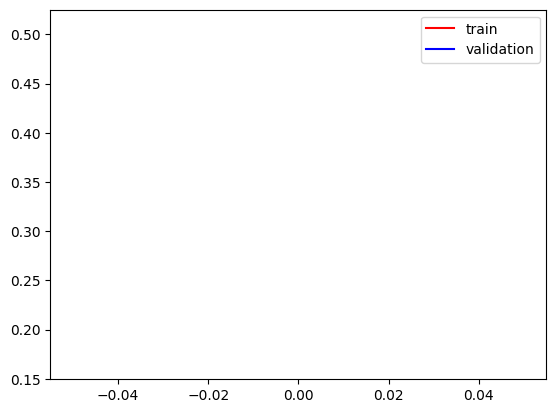

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

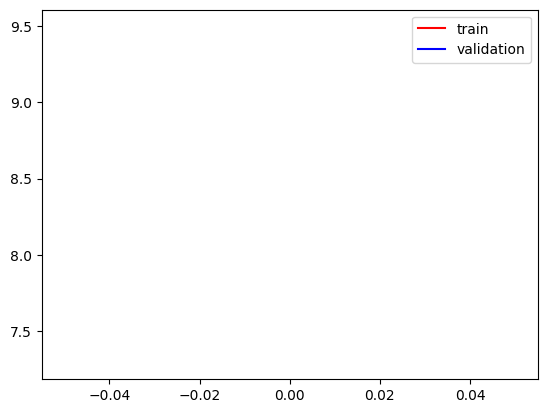

In [47]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# ways to reduce overfitting

# Add more data
# Data Augmentation -> next video
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [45]:
# Evaluate the model
validation_steps = validation_generator.samples // batch_size + 1
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

1/1 [==============================] - 1s 539ms/step


In [46]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(true_classes, predicted_classes)
classification_rep = classification_report(true_classes, predicted_classes, target_names=class_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[0 0 2 0 5]
 [0 0 1 0 5]
 [0 0 2 0 4]
 [0 0 0 0 6]
 [0 0 1 0 4]]

Classification Report:
               precision    recall  f1-score   support

   Black Soil       0.00      0.00      0.00         7
  Cinder Soil       0.00      0.00      0.00         6
Laterite Soil       0.33      0.33      0.33         6
    Peat Soil       0.00      0.00      0.00         6
  Yellow Soil       0.17      0.80      0.28         5

     accuracy                           0.20        30
    macro avg       0.10      0.23      0.12        30
 weighted avg       0.09      0.20      0.11        30



C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Prediction

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [22]:
# Load the saved model
saved_model_path = 'image_classification_model.h5'
loaded_model = load_model(saved_model_path)

In [23]:
# Load a test image for prediction
test_image_path = 'C:/Users/Abhishek_Jaiswal/Documents/EmbeddingALL/dataset/Soil types/Yellow Soil/13.jpg'
img = image.load_img(test_image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale to match the training data preprocessing

In [24]:
# Make predictions
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions)

1/1 [==============================] - 0s 234ms/step


In [25]:
# Map the class index back to class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The predicted class for the test image is: {predicted_label}")

The predicted class for the test image is: Yellow Soil


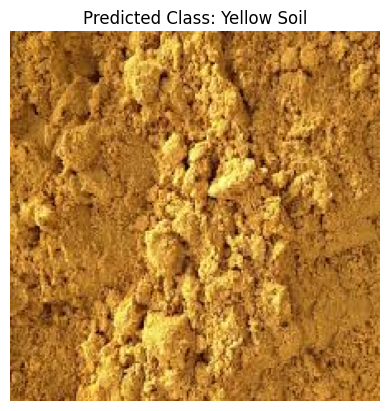

In [27]:
# Display the test image and prediction
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_label}")
plt.axis('off')
plt.show()

# Pretrained models in CNN

In [64]:
from keras.applications.vgg16 import VGG16
#Load the model
model = VGG16()

553467096/553467096 [==============================] - 48s 0us/step


In [65]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [68]:
from keras.utils import plot_model
#plot_model(model)

In [69]:
for i in range(len(model.layers)):
	# check for convolutional layer
	if 'conv' not in model.layers[i].name:
		continue
	# get filter weights
	filters, biases = model.layers[i].get_weights()
	print("layer number",i,model.layers[i].name, filters.shape)

layer number 1 block1_conv1 (3, 3, 3, 64)
layer number 2 block1_conv2 (3, 3, 64, 64)
layer number 4 block2_conv1 (3, 3, 64, 128)
layer number 5 block2_conv2 (3, 3, 128, 128)
layer number 7 block3_conv1 (3, 3, 128, 256)
layer number 8 block3_conv2 (3, 3, 256, 256)
layer number 9 block3_conv3 (3, 3, 256, 256)
layer number 11 block4_conv1 (3, 3, 256, 512)
layer number 12 block4_conv2 (3, 3, 512, 512)
layer number 13 block4_conv3 (3, 3, 512, 512)
layer number 15 block5_conv1 (3, 3, 512, 512)
layer number 16 block5_conv2 (3, 3, 512, 512)
layer number 17 block5_conv3 (3, 3, 512, 512)


In [70]:
# retrieve weights from the second hidden layer
filters , bias = model.layers[1].get_weights()

In [71]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

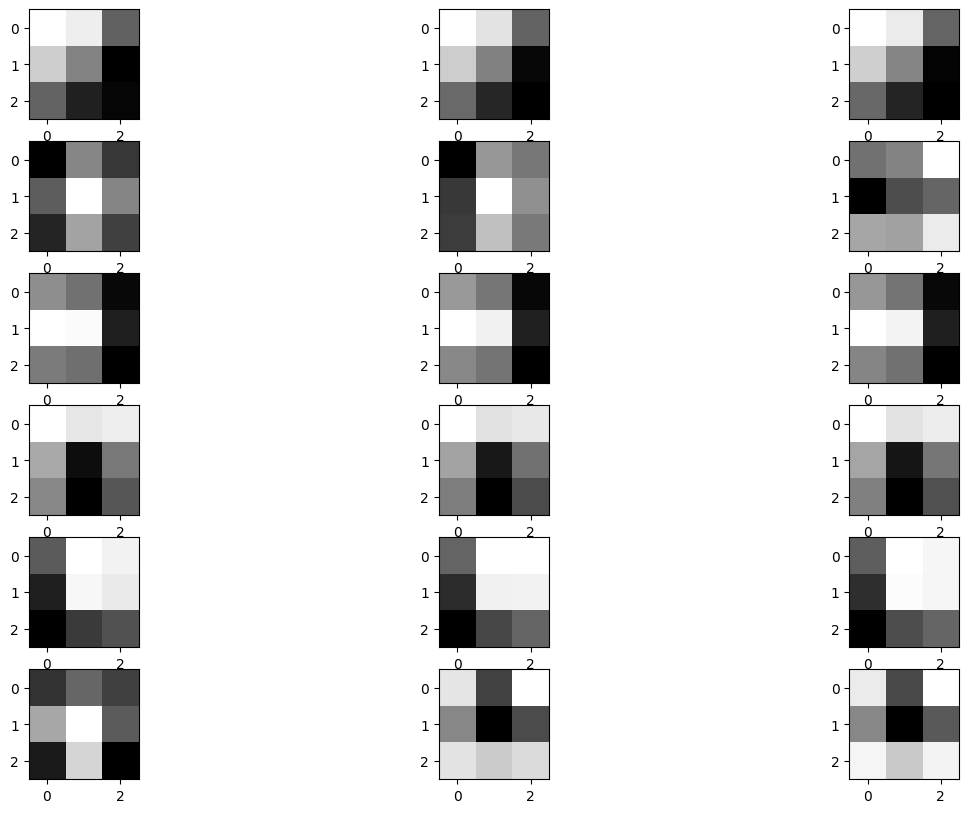

In [76]:
import matplotlib.pyplot as pyplot 
n_filters =6
ix=1
fig = pyplot.figure(figsize=(15,10))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        pyplot.subplot(n_filters,3,ix)
        pyplot.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
pyplot.show()

In [81]:
from tensorflow.keras.models import Model
model = Model(inputs=model.inputs , outputs=model.layers[1].output)

In [85]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input
image = load_img("C:/Users/Abhishek_Jaiswal/Documents/EmbeddingALL/dataset/Soil types/Yellow Soil/13.jpg" , target_size=(224,224))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

image = preprocess_input(image)

1/1 [==============================] - 0s 97ms/step


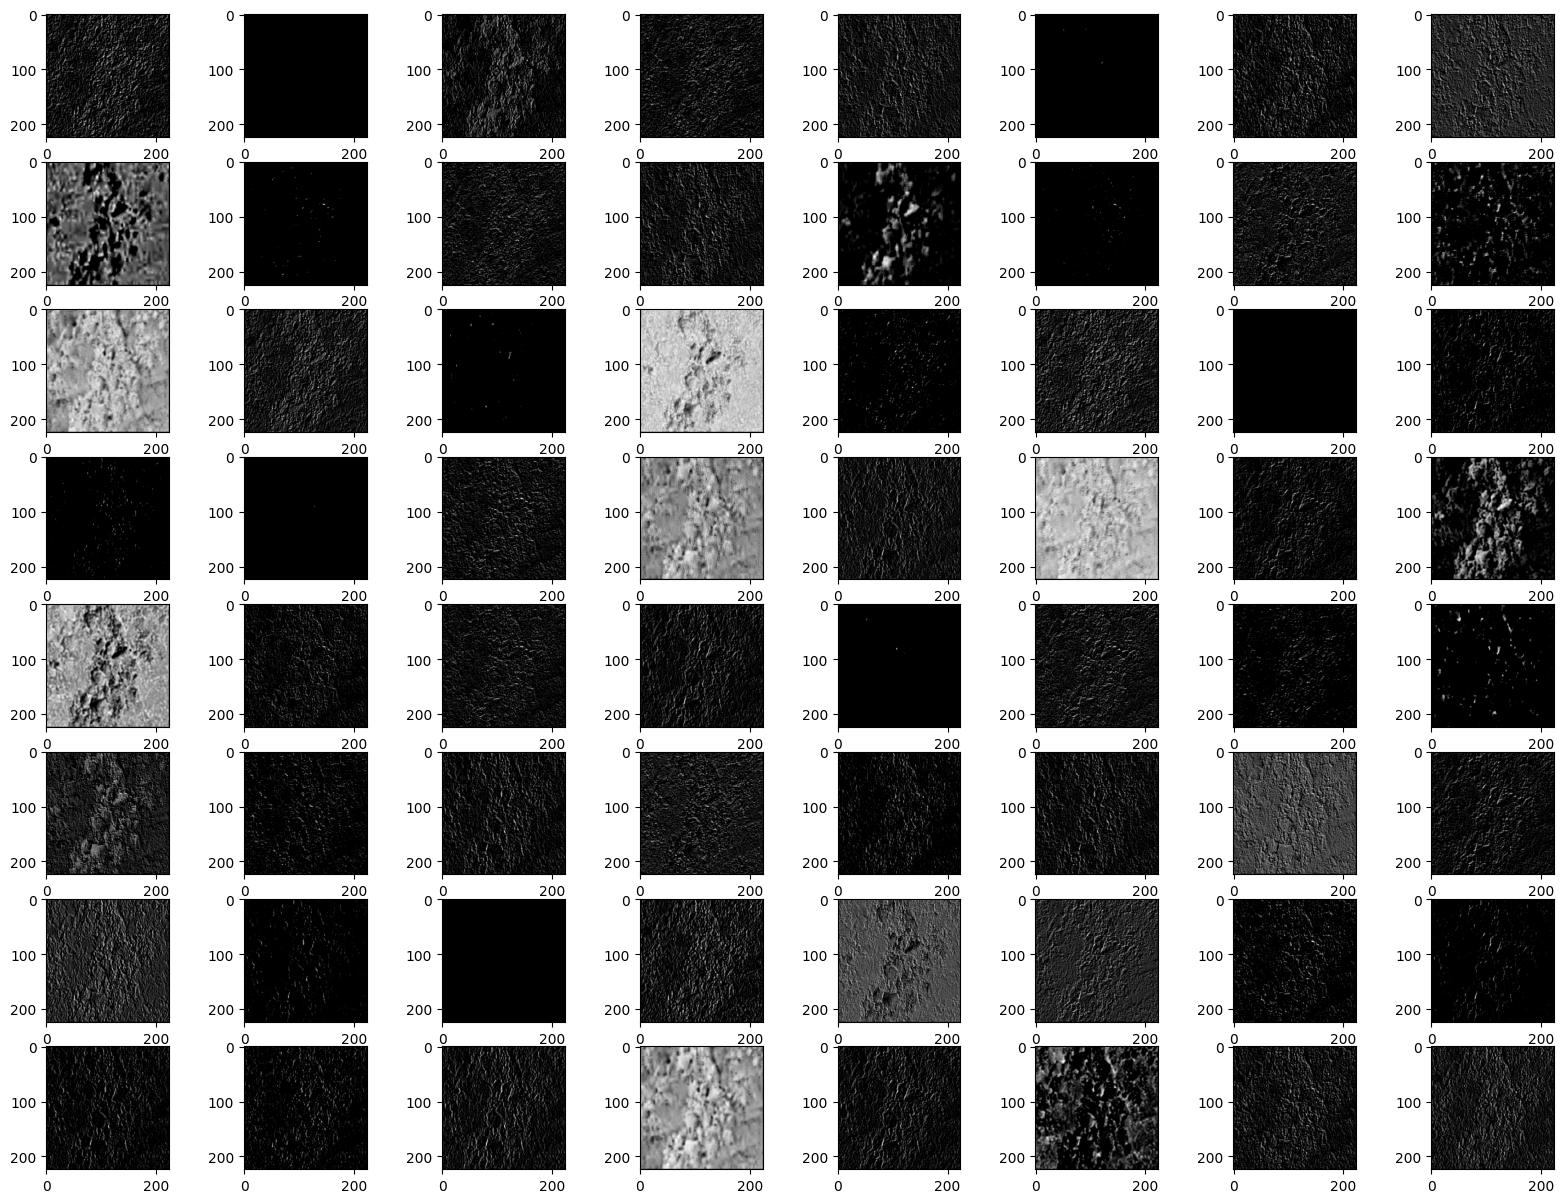

In [86]:
#calculating features_map
features = model.predict(image)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

## Visualizing CNN Filters and Feature Maps

In [87]:
model2 = VGG16()

In [88]:
layer_index = [ 2, 5 , 9 , 13 , 17]
outputs = [model2.layers[i].output for i in layer_index]

model3 = Model( inputs= model2.inputs, outputs = outputs)

1/1 [==============================] - 1s 527ms/step


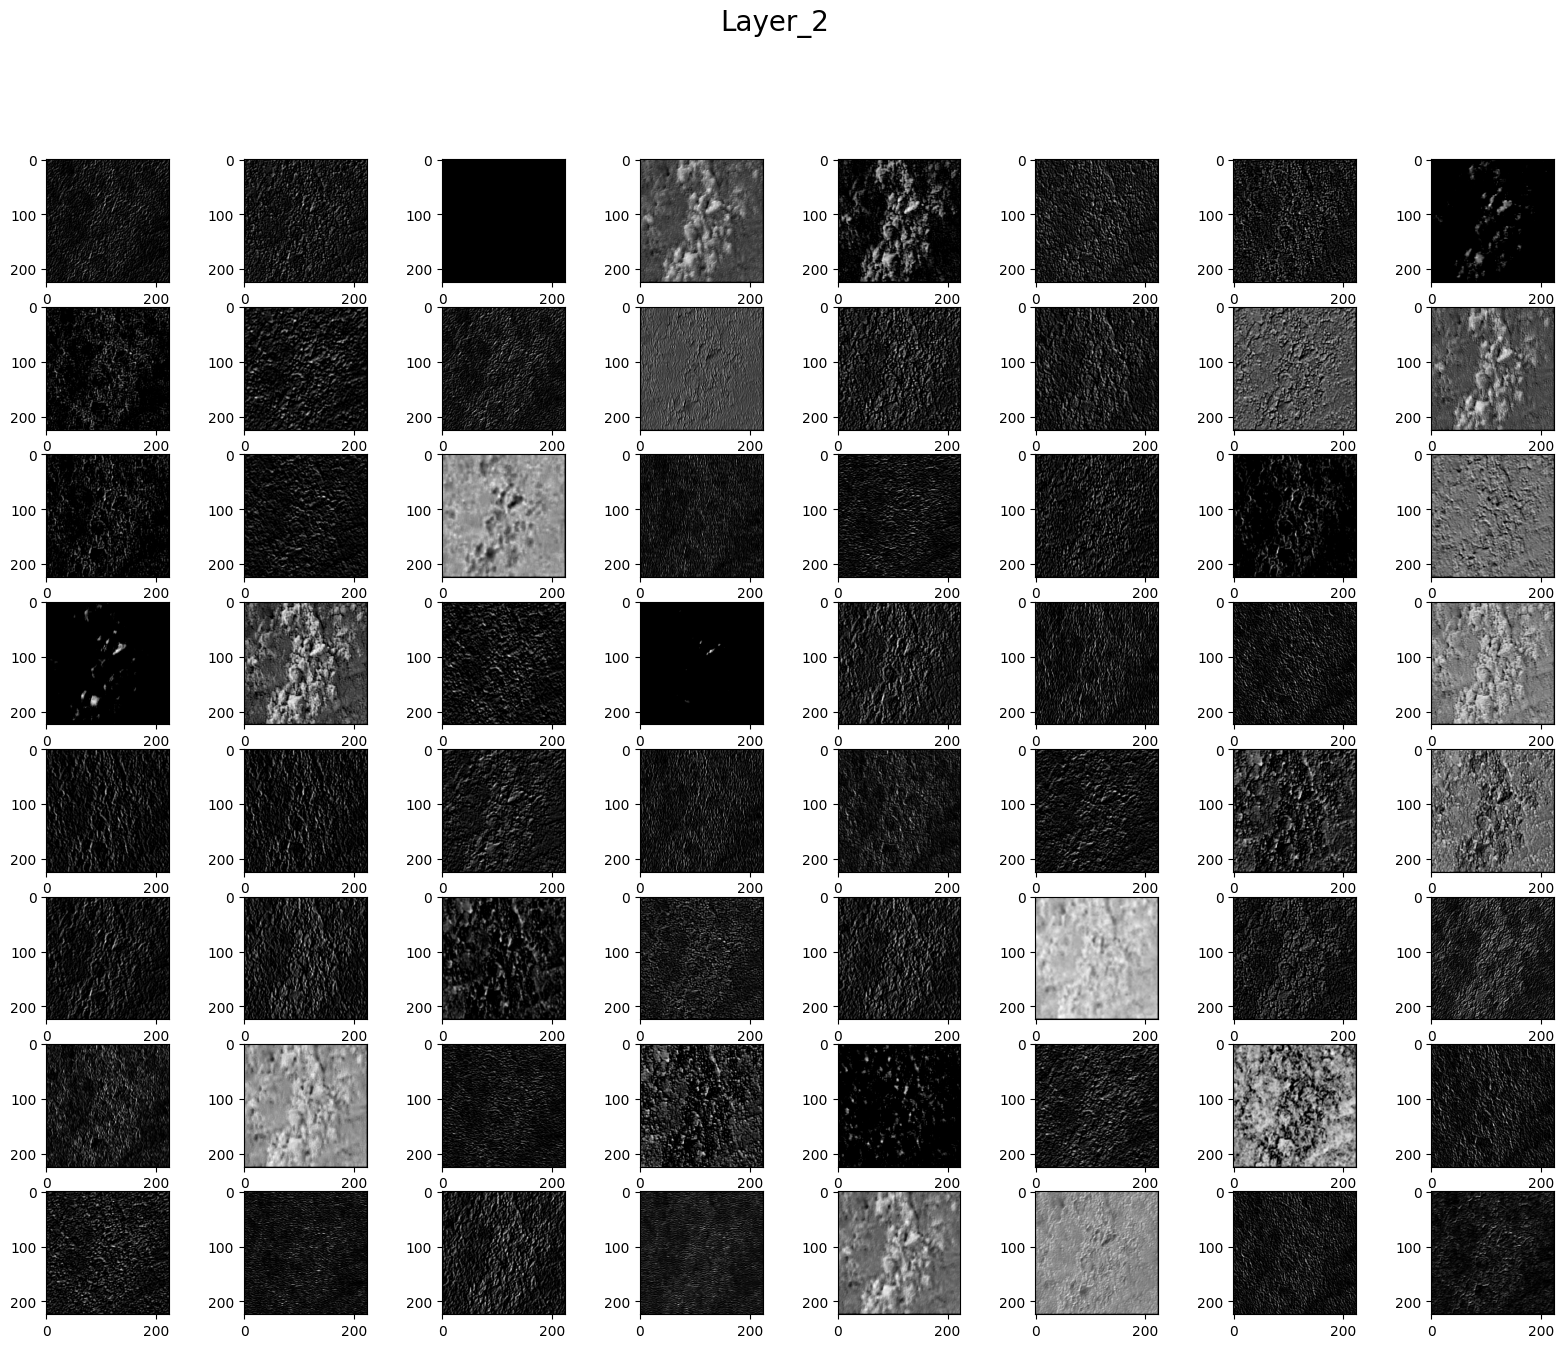

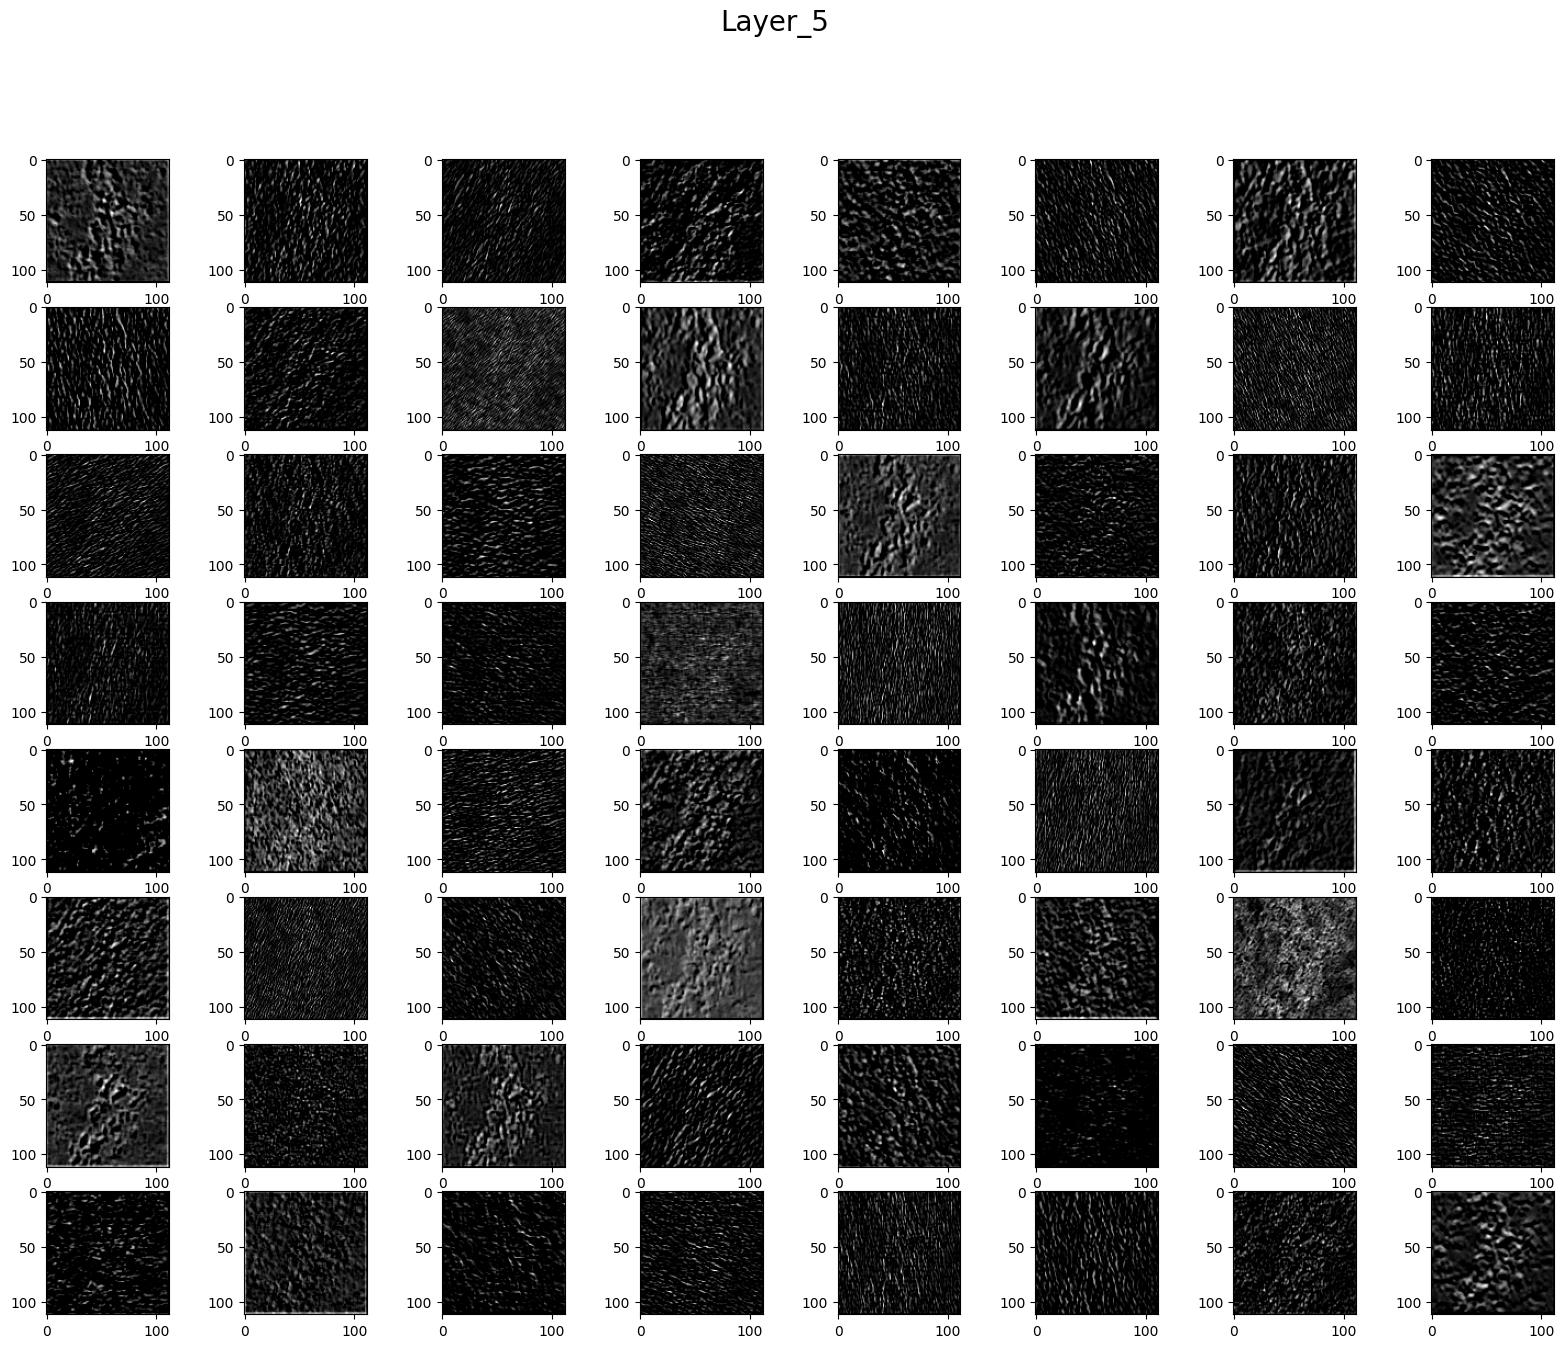

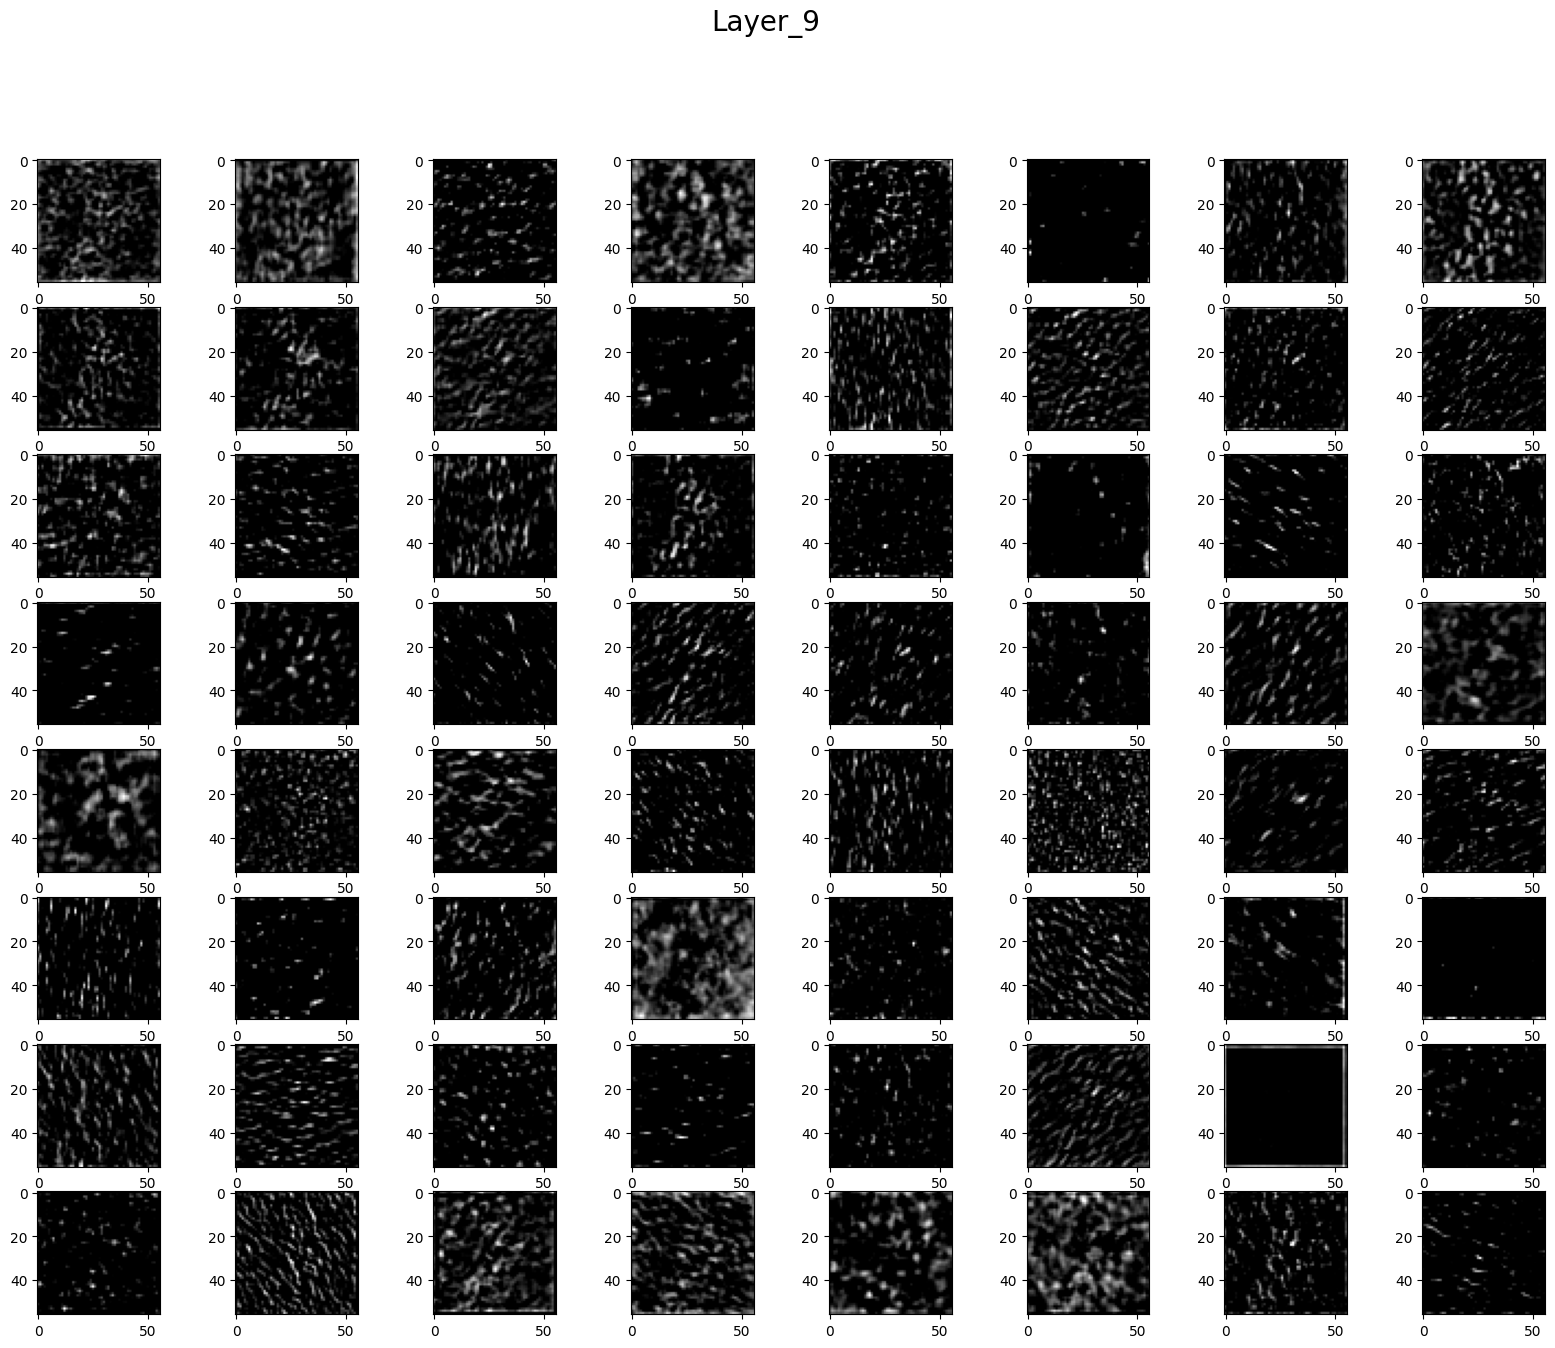

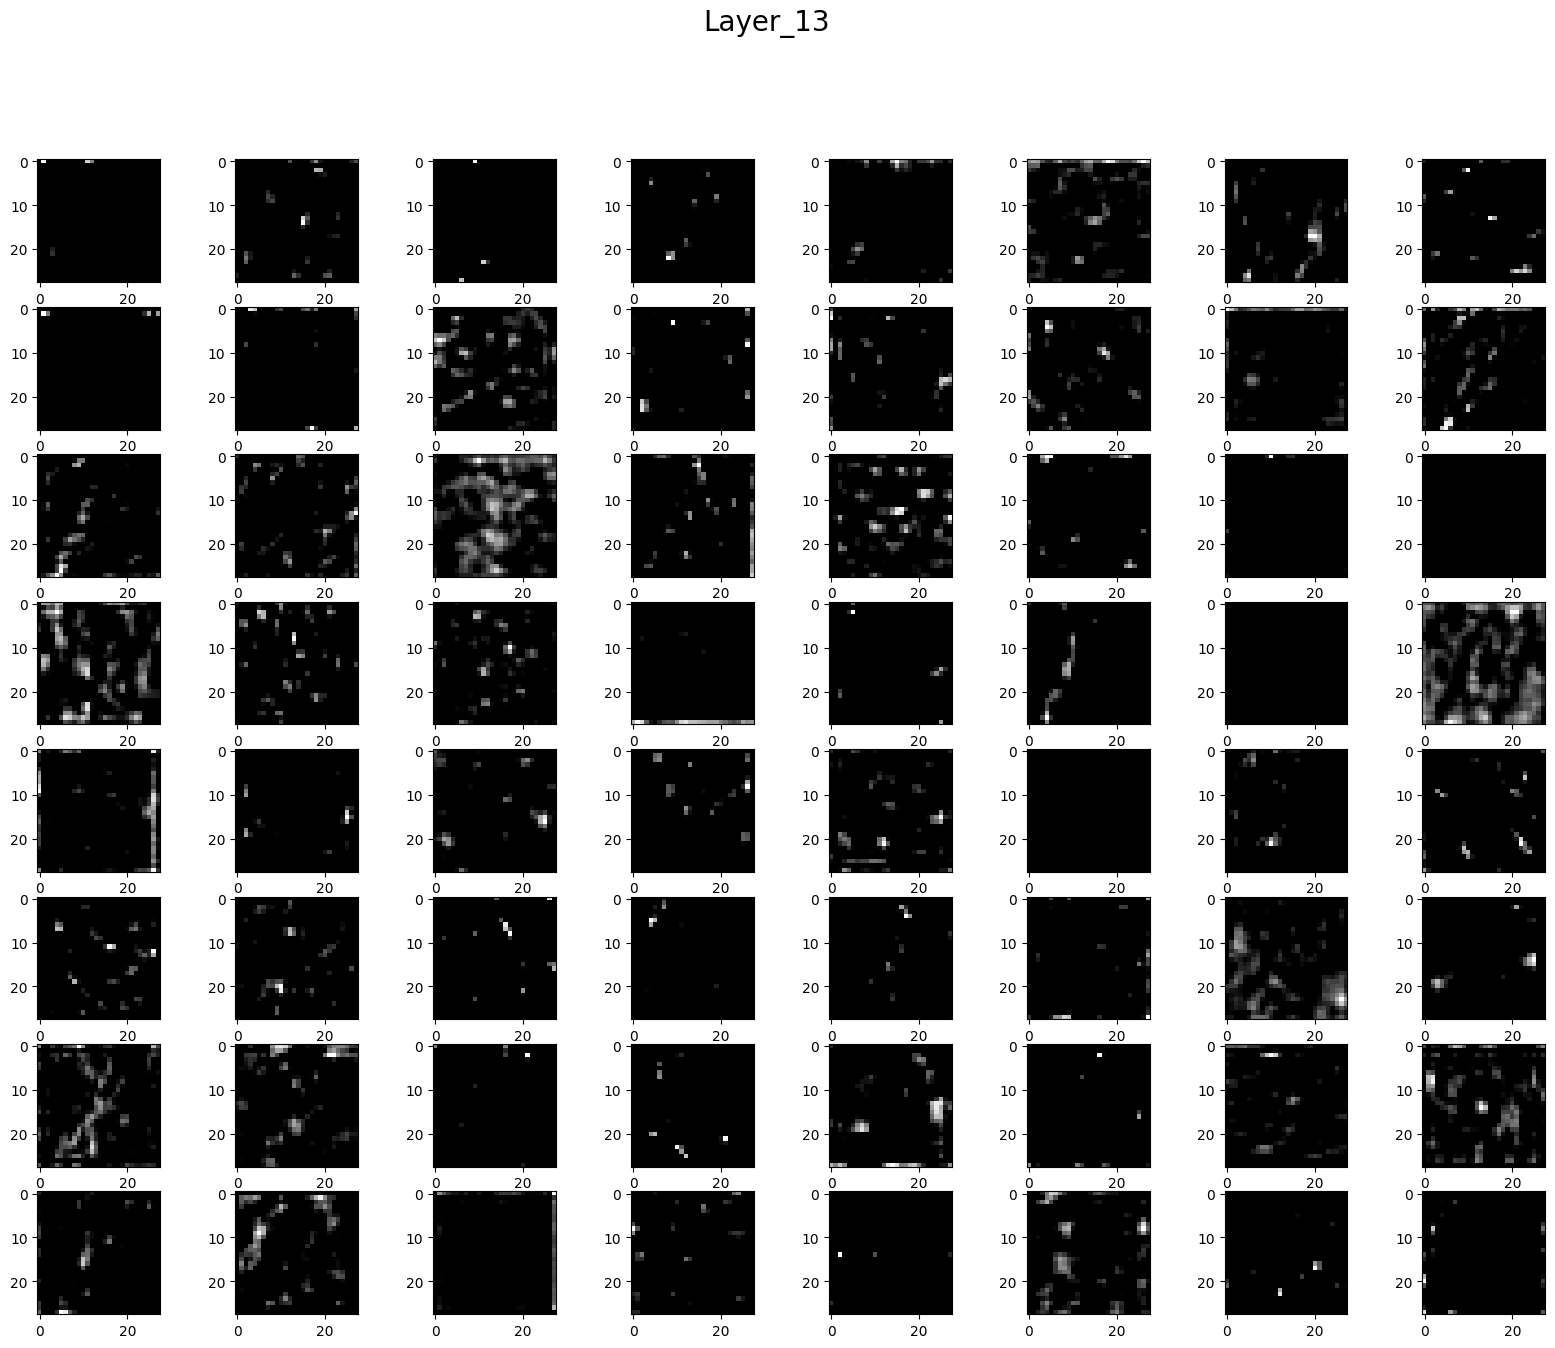

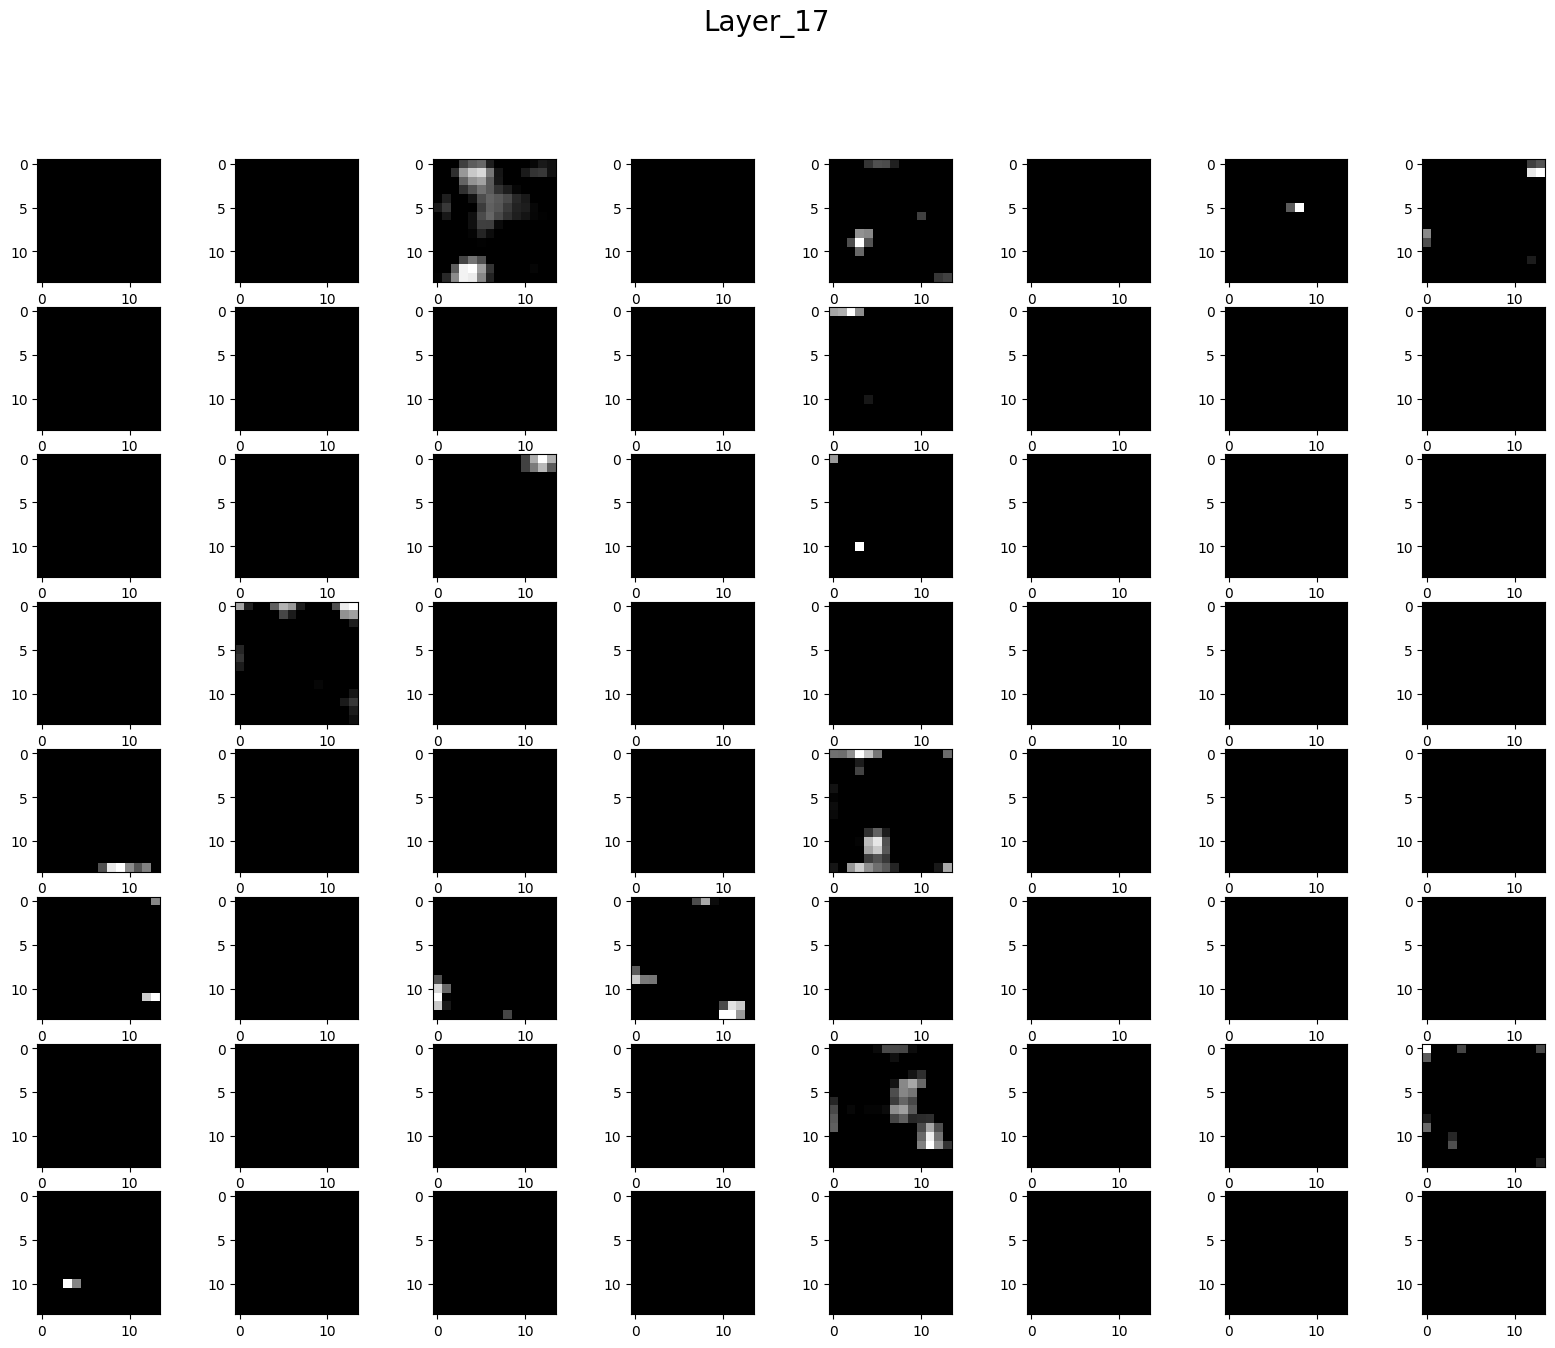

In [89]:
feature_map = model3.predict(image)

for i,fmap in zip(layer_index,feature_map):
    fig = pyplot.figure(figsize=(20,15))
    fig.suptitle("Layer_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        pyplot.subplot(8,8,i)
        pyplot.imshow(fmap[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

# Transfer-Learning & Finetuning

In [ ]:
#https://www.kaggle.com/c/dogs-vs-cats/data?select=test1.zip

In [92]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [93]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [94]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [95]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [96]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

In [ ]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Transfer-learning-feature-extraction(data-augmentation)

In [98]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [99]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [100]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [101]:
conv_base.trainable = False

In [102]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Transfer-learning-feature-extraction(without-data-augmentation)

In [103]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [104]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [105]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [106]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
conv_base.trainable = False

In [ ]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

In [ ]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# Keras Functional Model: Build non-linear Neural Networks

In [122]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# Generate dummy dataset
np.random.seed(42)
X_train = np.random.rand(1000, 10)  # 1000 samples with 10 features each
y_train = np.random.randint(2, size=(1000,))  # Binary labels (0 or 1)

# Define the input layer
input_layer = Input(shape=(10,))

# Hidden layers
hidden_layer_1 = Dense(64, activation='relu')(input_layer)
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)

# Output layer
output_layer = Dense(1, activation='sigmoid')(hidden_layer_2)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_21 (Dense)            (None, 64)                704       
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 2s 19ms/step - loss: 0.6984 - accuracy: 0.4863 - val_loss: 0.6961 - val_accuracy: 0.5100
Epoch 2/10
25/25

In [123]:
# Generate dummy test dataset
X_test = np.random.rand(200, 10)  # 200 samples with 10 features each
y_test = np.random.randint(2, size=(200,))  # Binary labels (0 or 1)

# Make predictions on the test set
predictions = model.predict(X_test)

# Convert predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Evaluate the model
accuracy = np.mean(binary_predictions == y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Alternatively, you can use the evaluate method provided by Keras
evaluation = model.evaluate(X_test, y_test)
print(f'Evaluation results: {evaluation}')


7/7 [==============================] - 0s 2ms/step
Accuracy: 49.30%
7/7 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.4800
Evaluation results: [0.6991379261016846, 0.47999998927116394]


The Keras functional API for building non-linear neural networks is particularly useful in various scenarios, and you might consider using it when:

Complex Model Architectures:

When your neural network architecture involves non-linear connections, shared layers, or multiple inputs/outputs.
The functional API allows for more flexibility in designing complex architectures compared to the sequential API.
Multiple Inputs or Outputs:

If your model requires multiple input streams or produces multiple outputs.
For tasks like multi-modal learning, where information from different sources needs to be integrated.
Shared Layers:

When you want to share layers between different parts of your model.
This is common in siamese networks, where two inputs share the same set of weights.
Dynamic Architecture:

When you need a dynamic and flexible architecture that can handle different input shapes.
The functional API supports dynamic computation graphs, making it suitable for a variety of input scenarios.
Custom Losses or Metrics:

If you need to define custom loss functions or metrics for your specific problem.
The functional API allows more control over the computation graph and thus the ability to implement custom behaviors.
Transfer Learning:

When you are working with pre-trained models and want to adapt them for a specific task.
You can easily incorporate pre-trained layers into your model using the functional API.
Research and Experimentation:

In research scenarios where you might want to experiment with novel architectures or explore unique model structures.
The functional API provides a powerful and flexible interface for such experimentation.
Debugging and Visualization:

If you need to debug or visualize different parts of your model.
The functional API allows you to access intermediate layers and outputs, aiding in model understanding and debugging.
It's important to note that for simpler sequential models, the sequential API in Keras might be more convenient. The choice between the functional API and the sequential API depends on the complexity of your model and the specific requirements of your task. The functional API is often chosen when more flexibility and customization are needed.





